# Evaluation for Pycox model

In this notebook we introduce the use of `PycoxEvaluator` in the package through an example dataset and model.
The first half of this notebook follows the procedure described in the Pycox [example](https://github.com/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In the following we will:

1. Load the METABRIC survival dataset and create a `LogisticHazard` model.
2. Train the model using training set.
3. Evaluate the performance using the concordance, Brier score, L1 loss, 1-calibration, and D-calibration.

# Import Dependencies
Note: You need `sklearn-pandas` for normalizing the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard

from Evaluator import PycoxEvaluator

Set seed for torch and numpy

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

Load the dataset, split it into training (64%), validation (16%) and testing set (20%).
Then standardize the covariates.

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

Build the model and train it.

In [4]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
durations_train, events_train = get_target(df_train)

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.9332,	val_loss: 2.7593
1:	[0s / 0s],		train_loss: 2.6493,	val_loss: 2.5245
2:	[0s / 0s],		train_loss: 2.3807,	val_loss: 2.2181
3:	[0s / 0s],		train_loss: 2.0595,	val_loss: 1.8908
4:	[0s / 0s],		train_loss: 1.7514,	val_loss: 1.6019
5:	[0s / 0s],		train_loss: 1.5335,	val_loss: 1.4371
6:	[0s / 0s],		train_loss: 1.4379,	val_loss: 1.3759
7:	[0s / 0s],		train_loss: 1.3954,	val_loss: 1.3658
8:	[0s / 0s],		train_loss: 1.3906,	val_loss: 1.3619
9:	[0s / 0s],		train_loss: 1.3730,	val_loss: 1.3531
10:	[0s / 0s],		train_loss: 1.3605,	val_loss: 1.3486
11:	[0s / 0s],		train_loss: 1.3349,	val_loss: 1.3513
12:	[0s / 0s],		train_loss: 1.3153,	val_loss: 1.3488
13:	[0s / 0s],		train_loss: 1.3133,	val_loss: 1.3418
14:	[0s / 0s],		train_loss: 1.2988,	val_loss: 1.3432
15:	[0s / 0s],		train_loss: 1.3079,	val_loss: 1.3525
16:	[0s / 0s],		train_loss: 1.2976,	val_loss: 1.3565
17:	[0s / 0s],		train_loss: 1.2918,	val_loss: 1.3577
18:	[0s / 0s],		train_loss: 1.2900,	val_loss: 1.3594
19:

Make the prediction. `surv` is a Dataframe object with index represents the time coordinates, and values represents the survival curves.

In [5]:
surv = model.interpolate(10).predict_surv_df(x_test)

Build the evaluator. Training set information (`durations_train` and `events_train`) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.

In [6]:
eval = PycoxEvaluator(surv, durations_test, events_test, durations_train, events_train)

Calculate the concordance index. `ties` argument indicates the way ties should be handled.
`predicted_time_method` argument indicates whether using median or mean survival time as the predicted time.

In [7]:
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None", predicted_time_method="Median")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6396413582602061, meaning that the model can correctly order 30177 pairs among 47178 comparable pairs in the testing set.


Calculate the Brier score at time 175.

In [8]:
bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.21502646817531187.


Calculate the integrated Brier score across all the time range. You can specify the number of points to integral.
If not specify, the default setting will use the censored time points obtained from testing set.

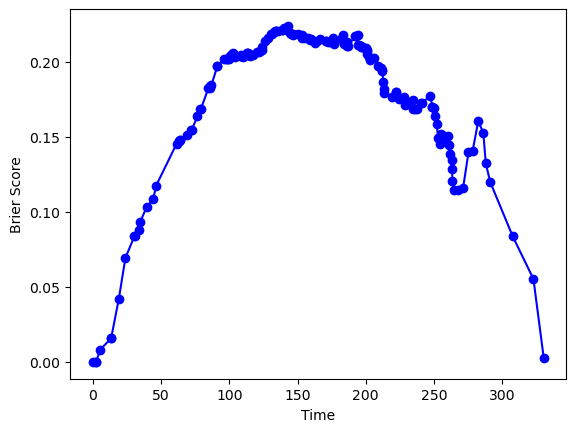

Integrated Brier score is 0.15237878267399446.


In [9]:
ibs = eval.integrated_brier_score(num_points=None, draw_figure=True)
print("Integrated Brier score is {}.".format(ibs))

Calculate the l1-margin loss using mean survival times obtain from the survival curves as the predicted survival times.
You can set `method` as 'Hinge' or 'Uncensored' for different l1 loss calculation.

In [10]:
l1 = eval.l1_loss(method='Margin', predicted_time_method="Mean")
print("L1-margin loss is {}.".format(l1))

/home/shiang/Documents/GithubRepository/SurvivalEVAL/Evaluations/util.py:187: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mean_survival_time, *rest = integrate.quad(_func_to_integral, 0, zero_probability_time,


L1-margin loss is 78.13500262009487.


Run one calibration test at 50% time of the testing set.

In [11]:
t_time = round(np.percentile(durations_test, 50))
p_value, ob, pre = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))

The model is one-calibrated at time 113.


Run distribution calibration test.

<Figure size 640x480 with 0 Axes>

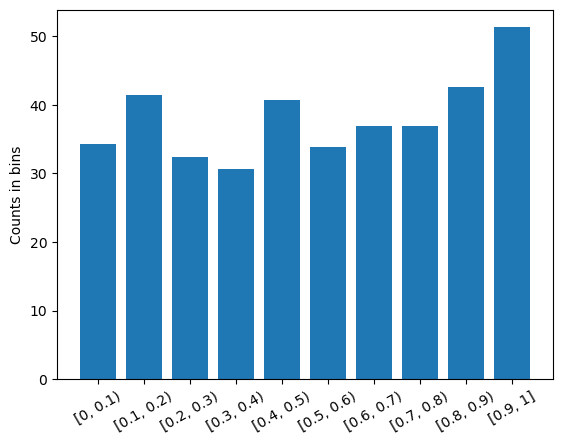

The model is d-calibrated!


In [12]:
p_value_2, bin_statistics = eval.d_calibration()
bins = ["[0, 0.1)", "[0.1, 0.2)", "[0.2, 0.3)", "[0.3, 0.4)", "[0.4, 0.5)", "[0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)",
        "[0.8, 0.9)", "[0.9, 1]"]
plt.clf()
fig, ax = plt.subplots()
ax.bar(bins, bin_statistics)
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylabel("Counts in bins")
plt.show()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")